# Cartpole with RBF. TD(lambda) method instead of TD(0)

First we import the graphic libs and we define a function to display the run

In [1]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tnrange, tqdm_notebook
import numpy as np
from collections import deque

%matplotlib inline

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

Now we create the environment (Mountain car V0)

In [2]:
import gym
env = gym.make("CartPole-v0").env

[2017-10-14 01:05:33,807] Making new env: CartPole-v0


Next we need to create the RBF network from sklearn lib. The first part will be the feature transformer, that transforms feature as a kernel approximator. We will use RBF with different gammas to have more granularity.

In [3]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from eligsgd import SGDRegressor

class FeatureTransformer:
    def __init__(self, env):
        # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        # NOTE!! state samples are poor, b/c you get velocities --> infinity
        observation_examples = np.random.random((20000, 4))*2 - 1
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
                ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
                ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
                ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
                ])
        feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

Next we want to create an StochasticGradientDescend regressor, that combined with the feature transformer, will lead to our implementation of the RBF. We will not use the sklearn regressor but we will create our own.

In [4]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        self.eligibilities = np.zeros((env.action_space.n, feature_transformer.dimensions))
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        return np.array([m.predict(X)[0] for m in self.models])

    def update(self, s, a, G, gamma, lambda_):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        self.eligibilities *= gamma * lambda_
        self.eligibilities[a] += X[0]
        self.models[a].partial_fit(X, [G], self.eligibilities[a])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

Then, we want to create a functions that executes one episode and update the model we pass to it 

In [5]:
def play_one(env, model, eps, gamma, lambda_, render=False):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    frames = []
    while not done and iters < 500:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        if done:
            reward = -200

        # update the model
        next = model.predict(observation)
        assert(len(next.shape) == 1)
        G = reward + gamma*np.max(next)
        model.update(prev_observation, action, G, gamma, lambda_)

        if reward == 1: # if we changed the reward to -200
            totalreward += reward
        iters += 1

    return totalreward, frames

In this final part, we instantiate everything we need and run the environment

Using numpy SGDRegressor with eligibility
Using numpy SGDRegressor with eligibility



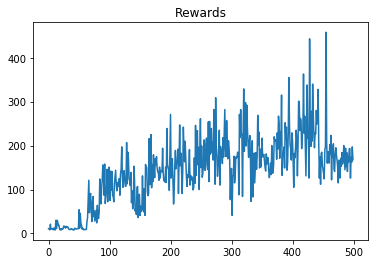

In [6]:
ft = FeatureTransformer(env)
model = Model(env, ft)
gamma = 0.99
lambda_ = 0.1

N_EPISODES = 500
totalrewards = np.empty(N_EPISODES)
for episode in tqdm_notebook(range(N_EPISODES), desc='Episodes'):
    eps = 1.0/np.sqrt(episode+1)
    totalreward, _ = play_one(env, model, eps, gamma, lambda_)
    totalrewards[episode] = totalreward

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

Now we want to run the environment with the actions specified by the policy and display it


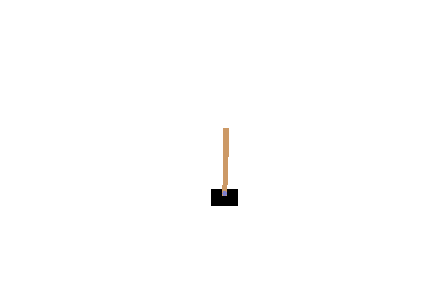
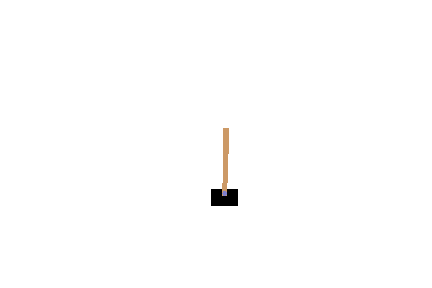
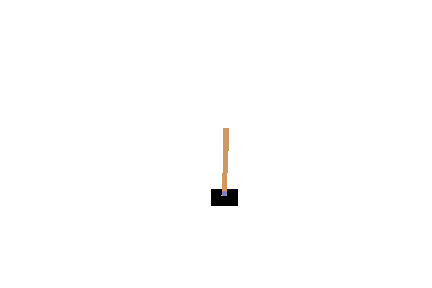
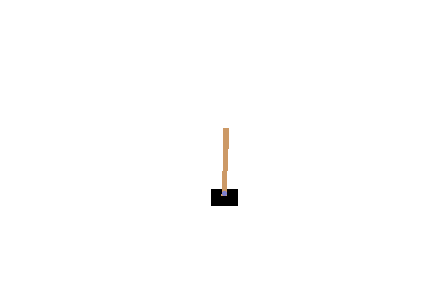
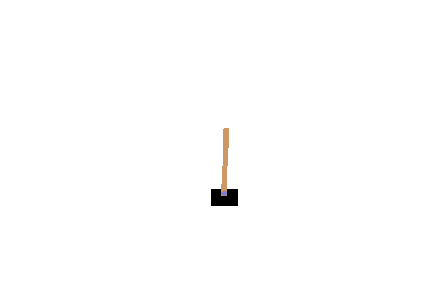
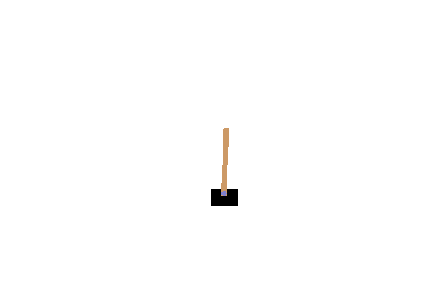
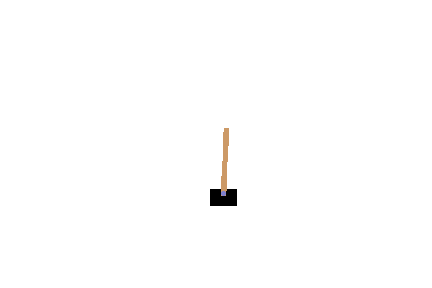
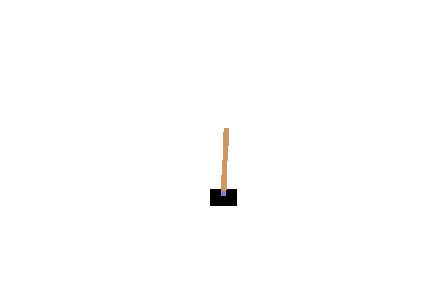
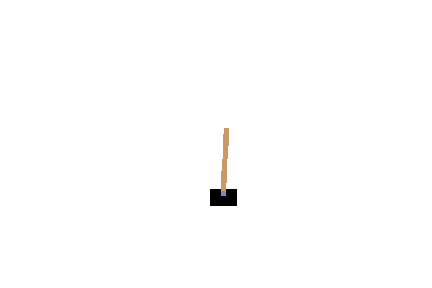
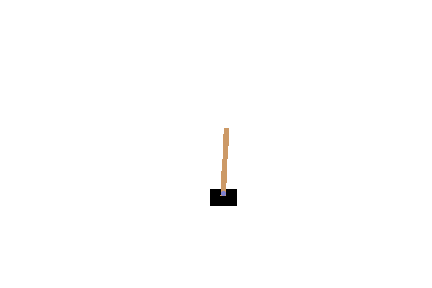
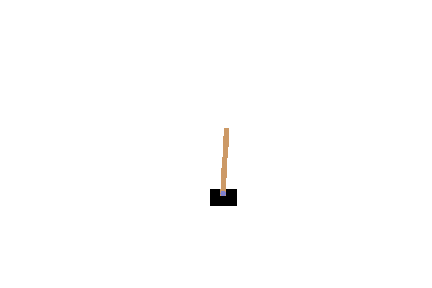
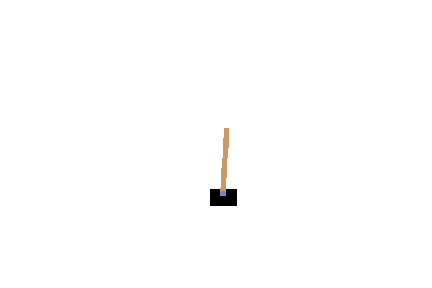
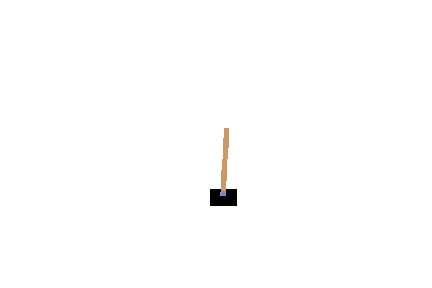
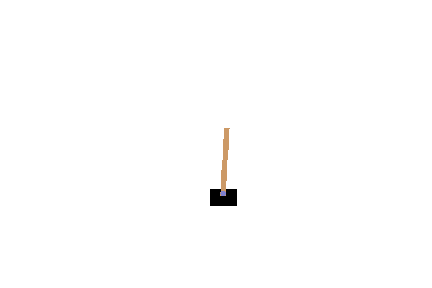
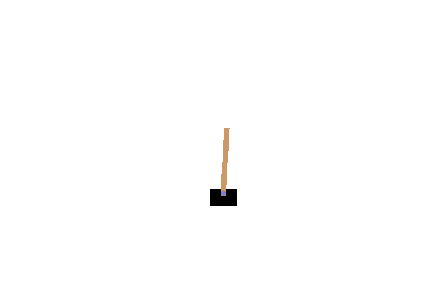
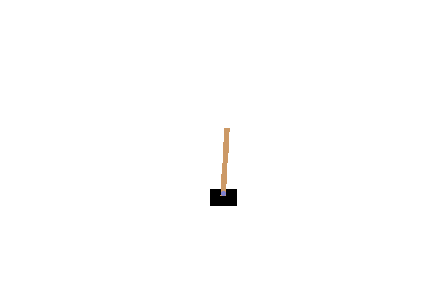
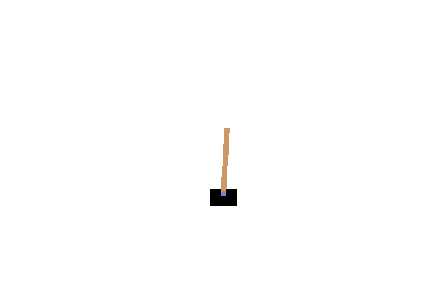
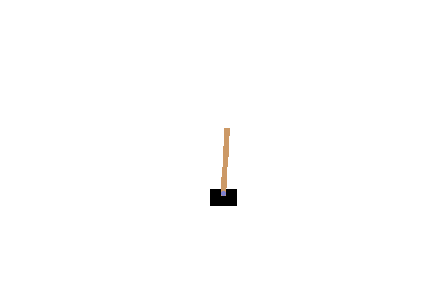
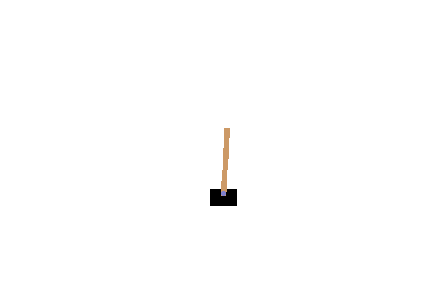
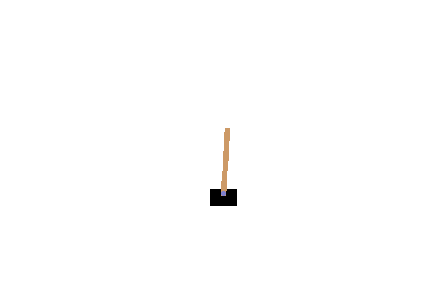
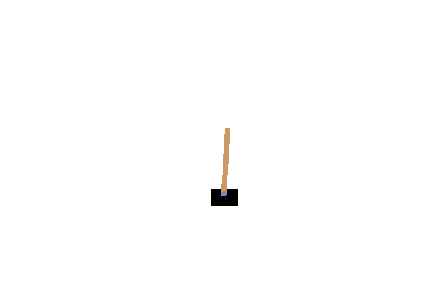
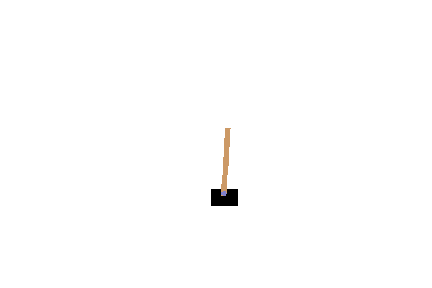
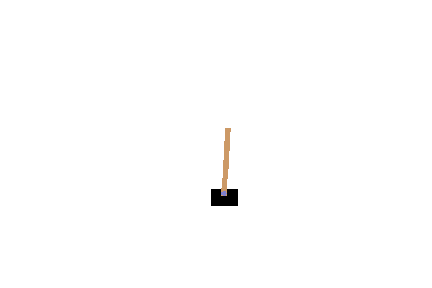
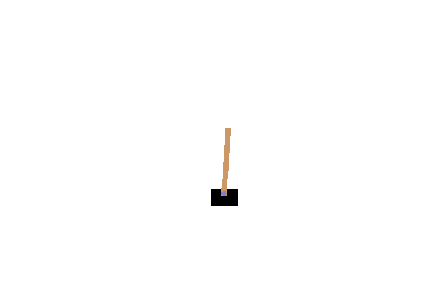
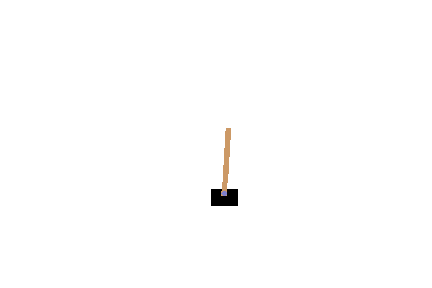
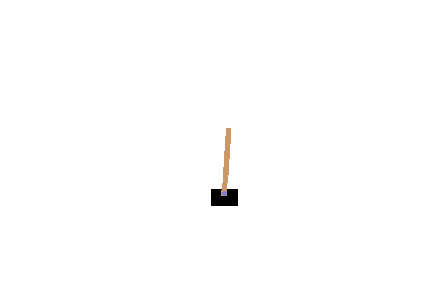
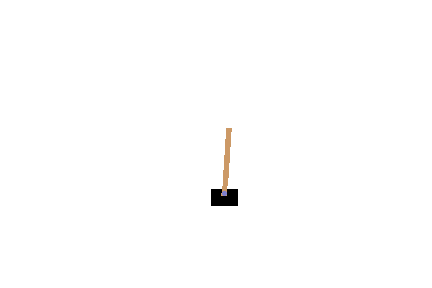
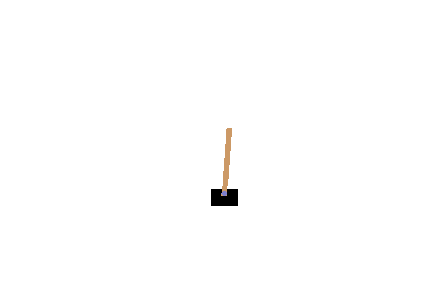
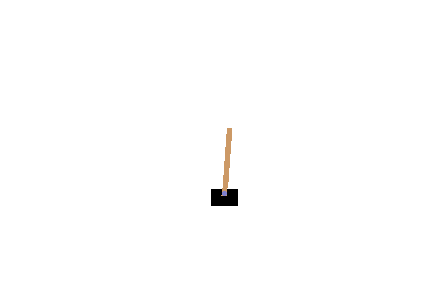
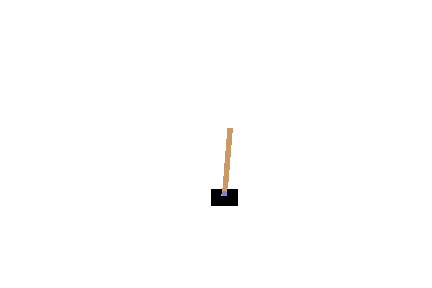
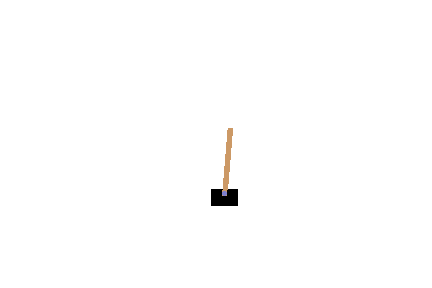
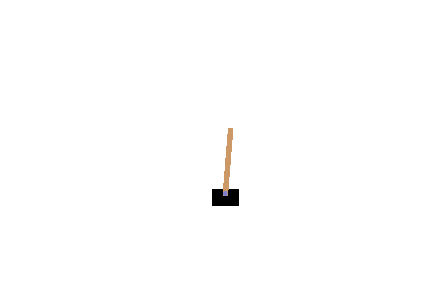
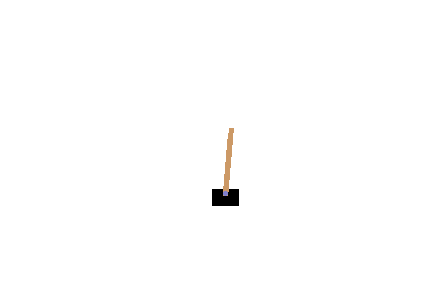
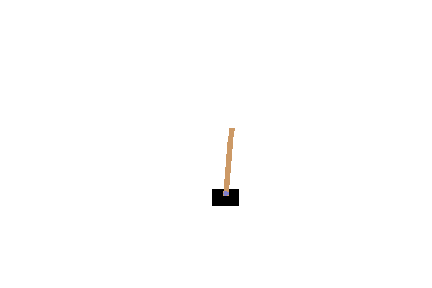
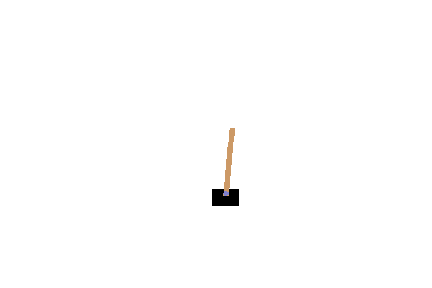
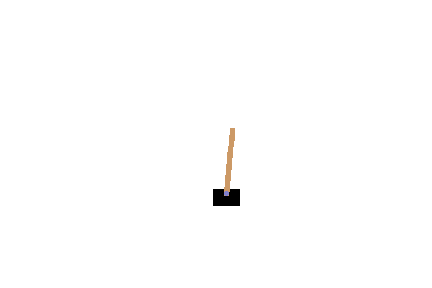
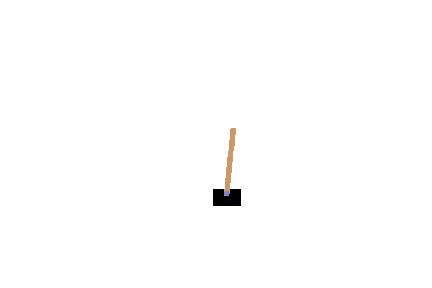
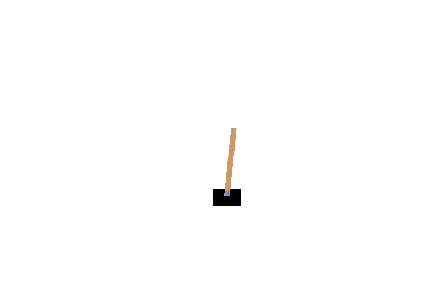
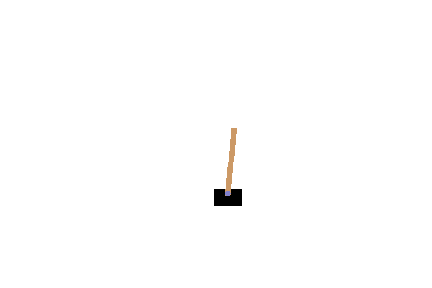
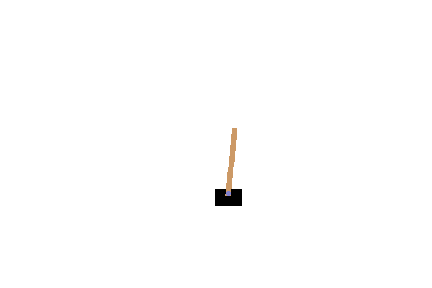
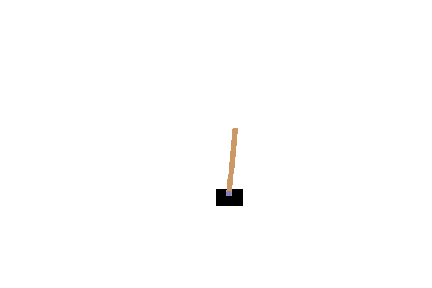
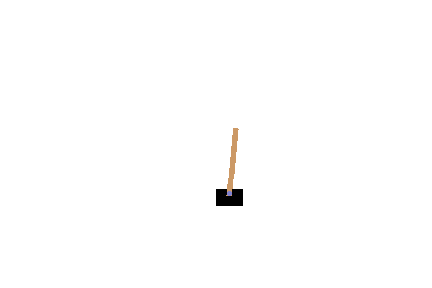
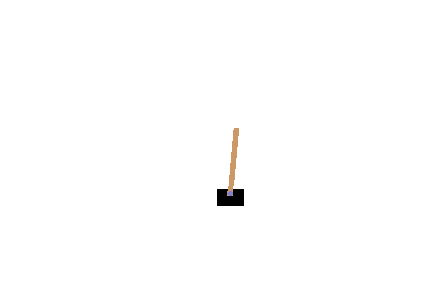
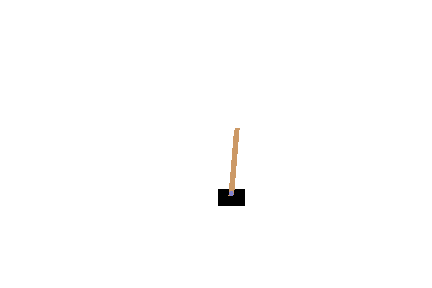
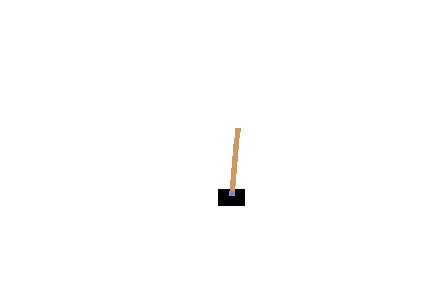
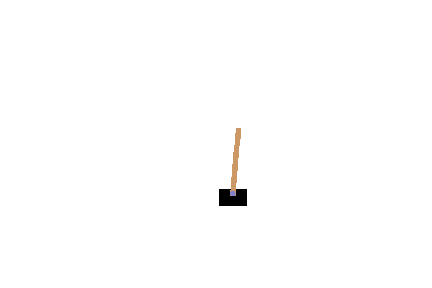
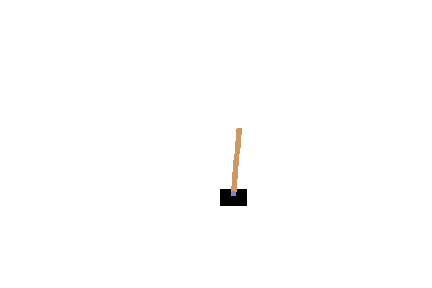
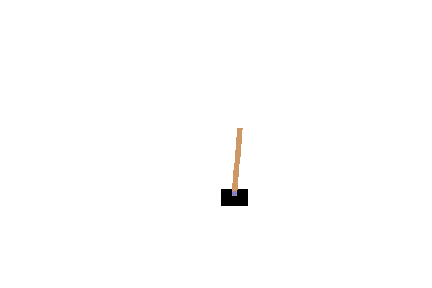
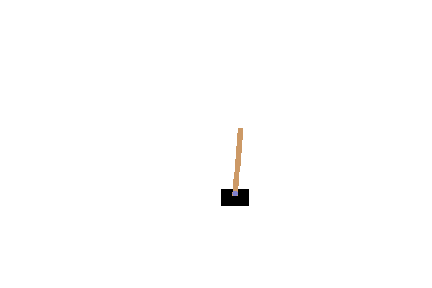
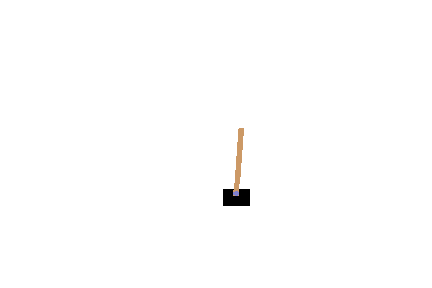
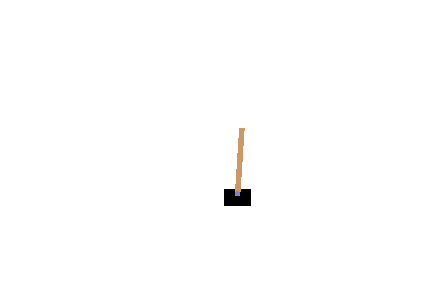
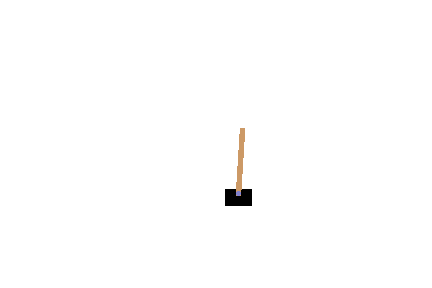
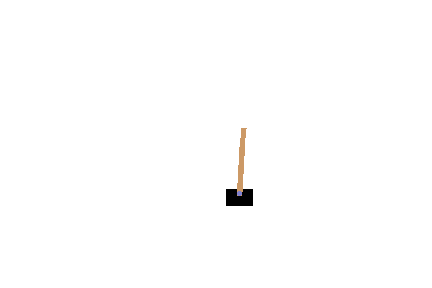
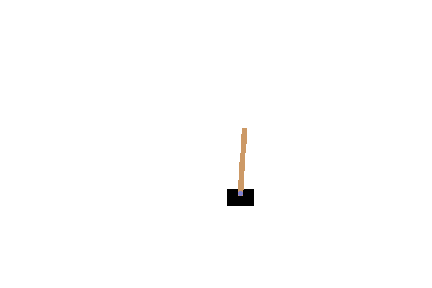
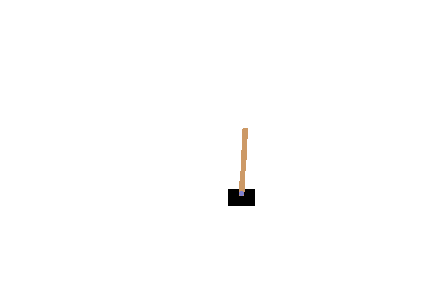
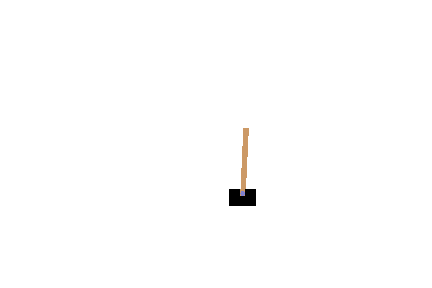
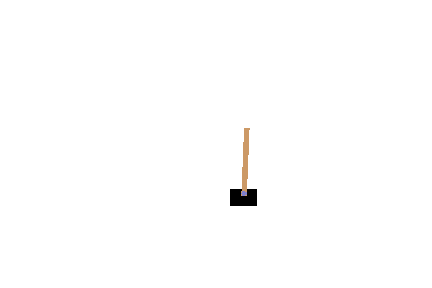
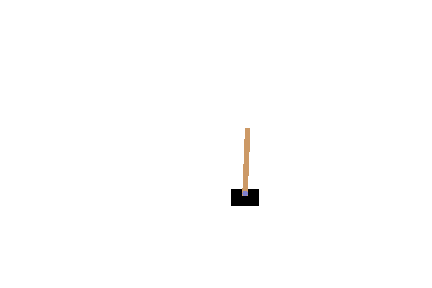
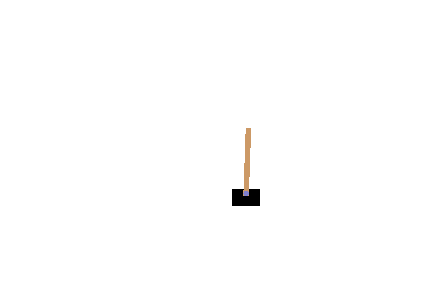
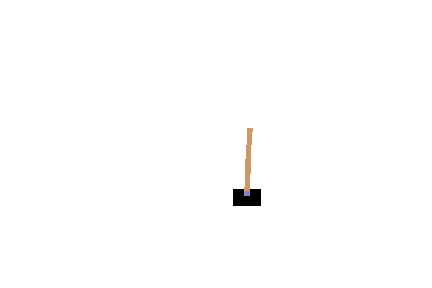
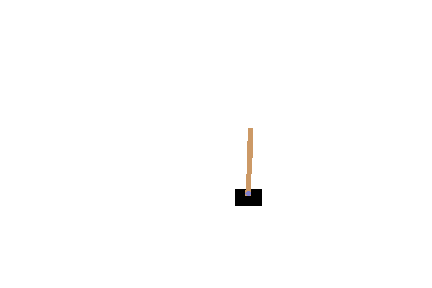
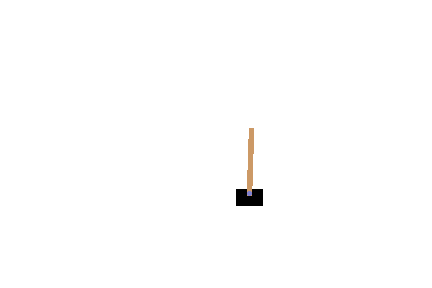
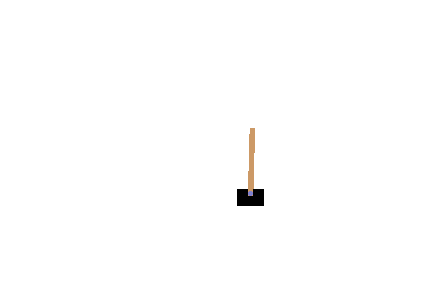
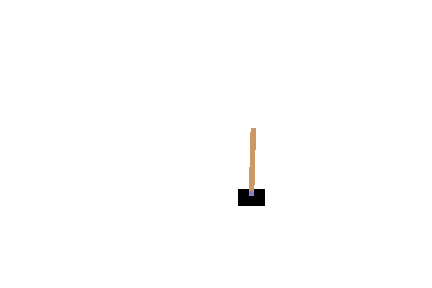
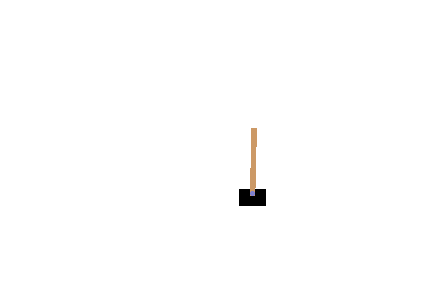
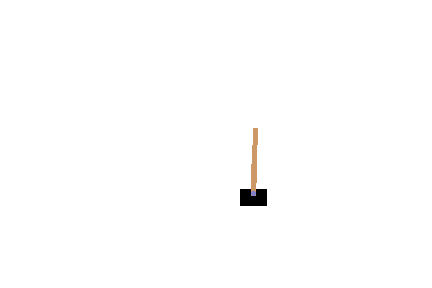
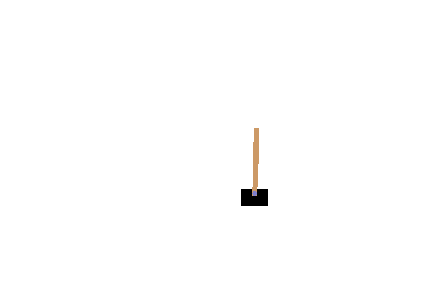
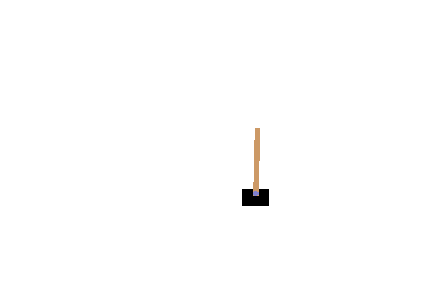
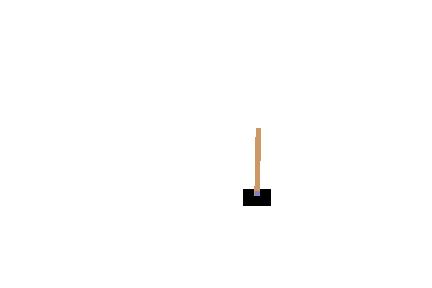
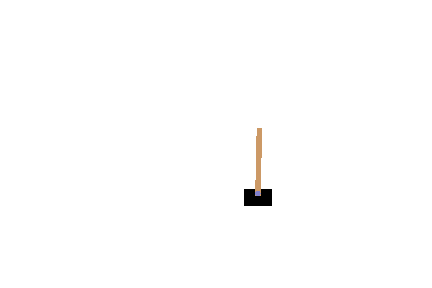
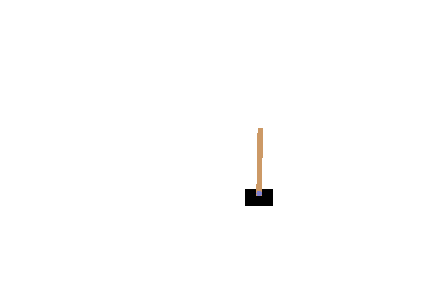
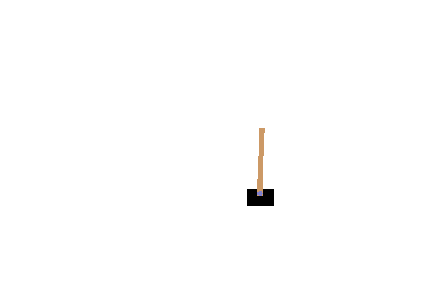
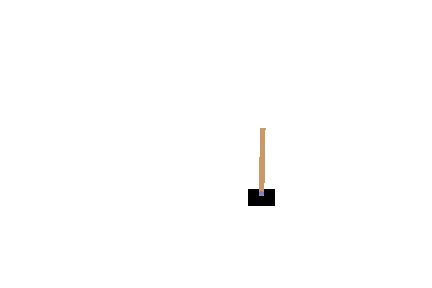
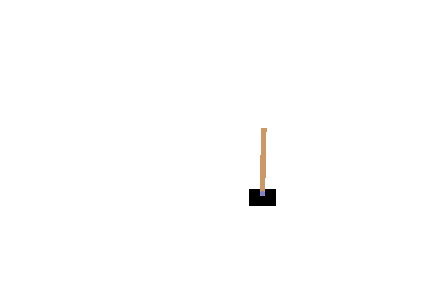
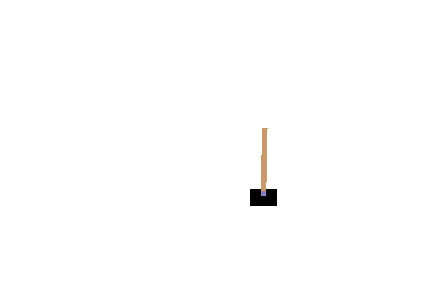
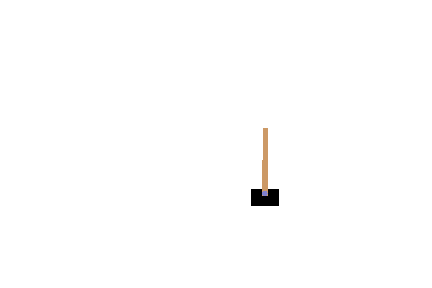
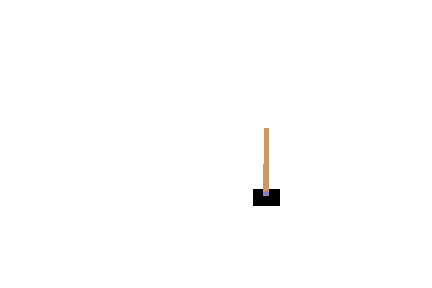
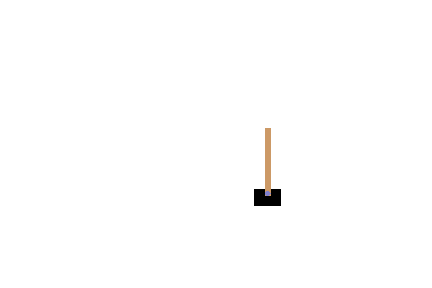
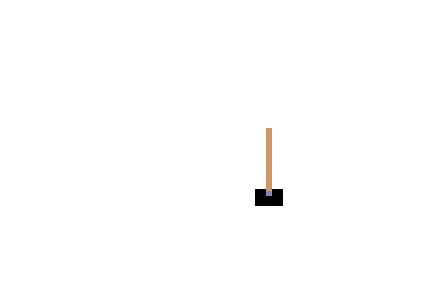
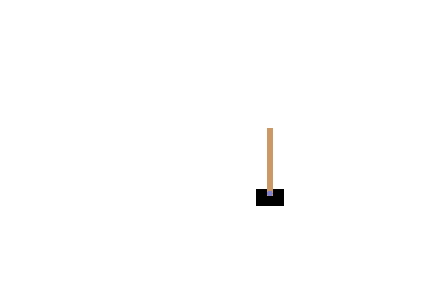
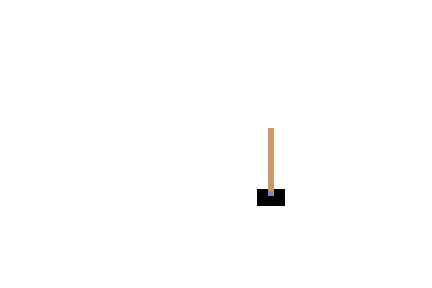
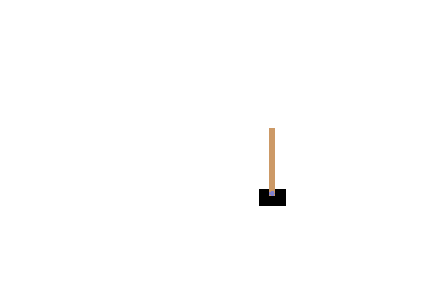
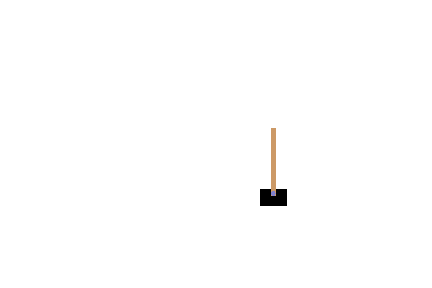
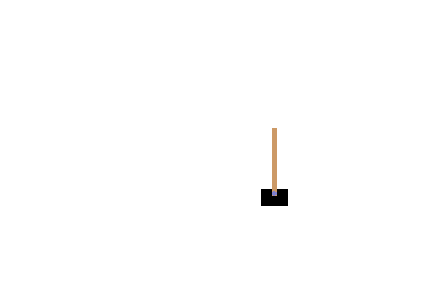
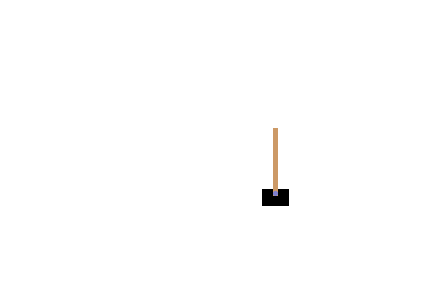
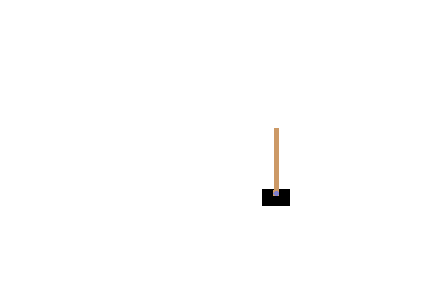
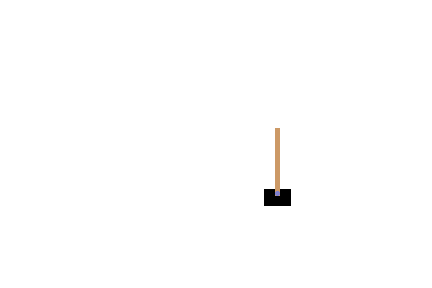
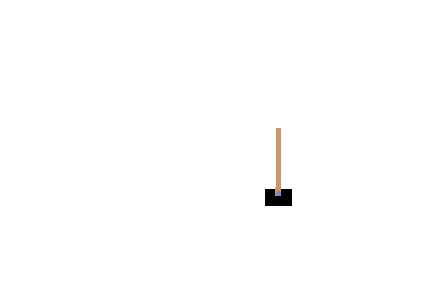
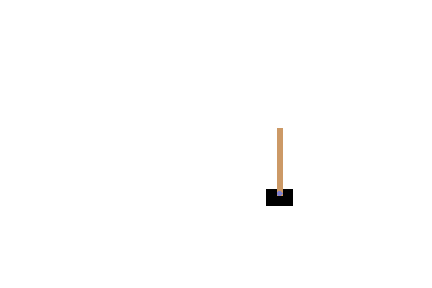
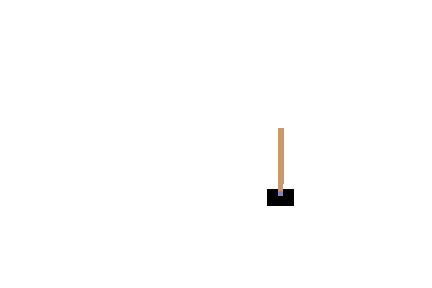
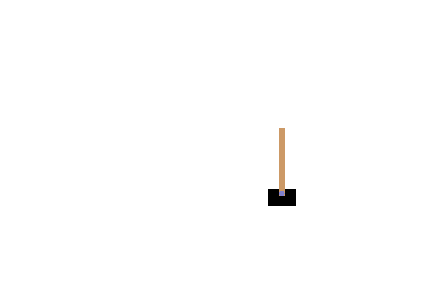
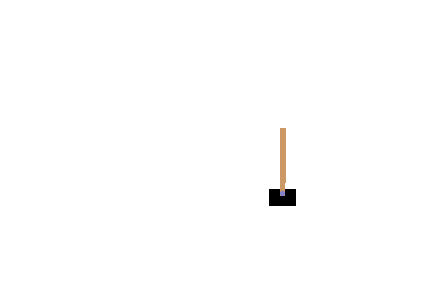
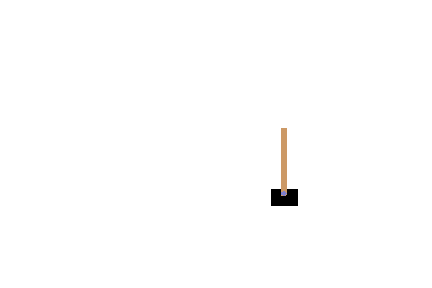
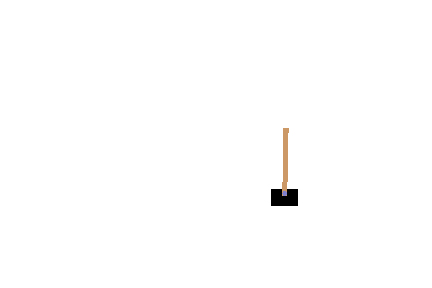
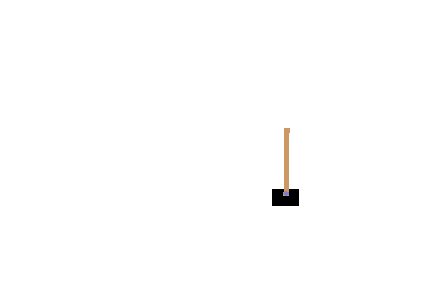
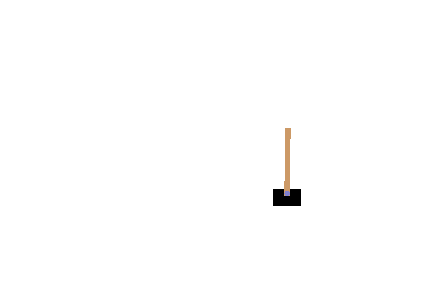
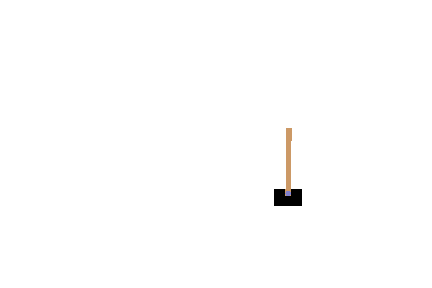
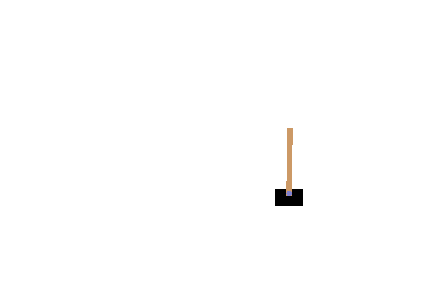
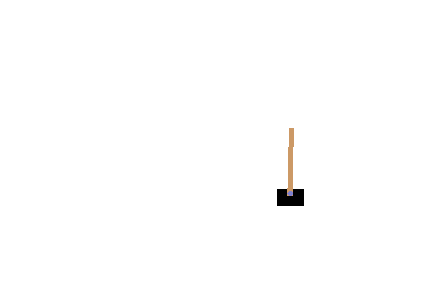
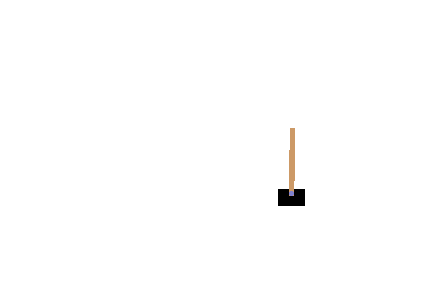
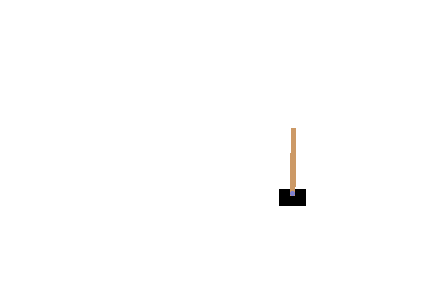
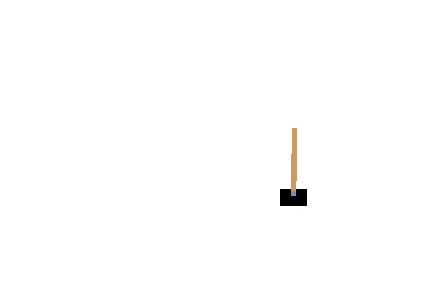
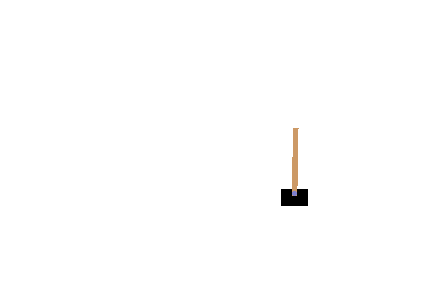
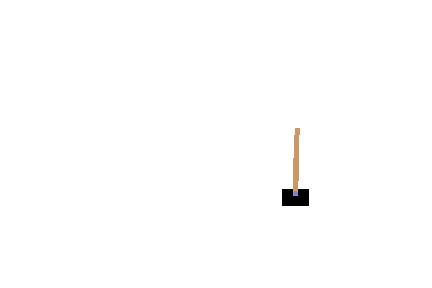
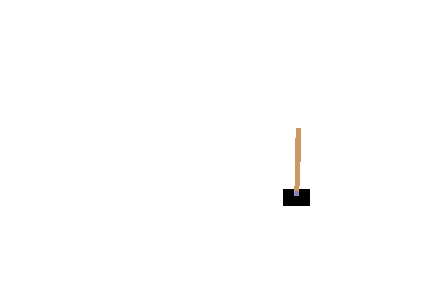
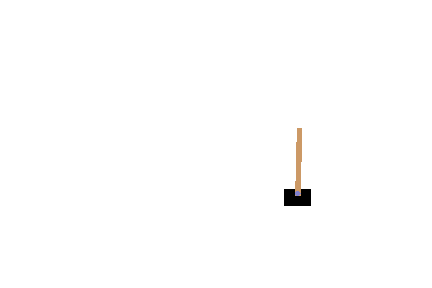
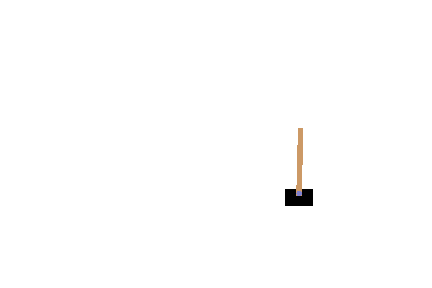
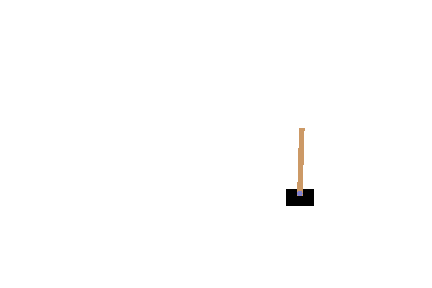
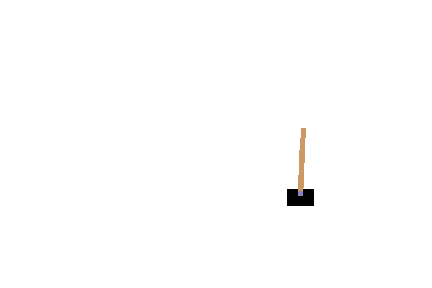
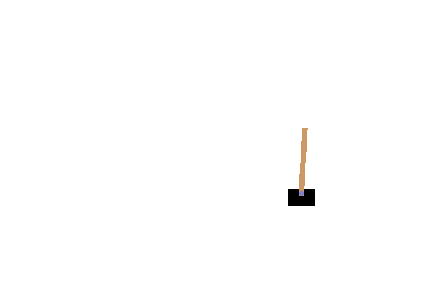
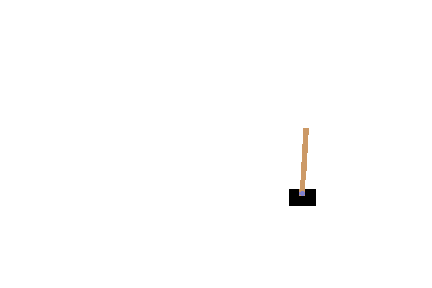
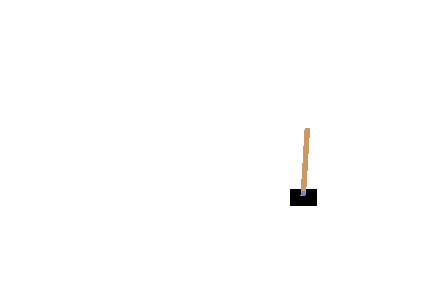
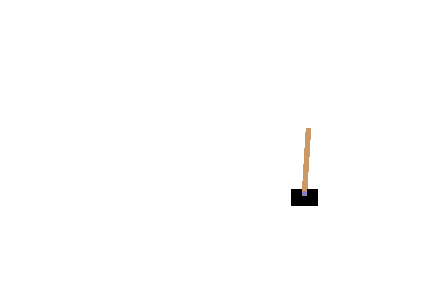
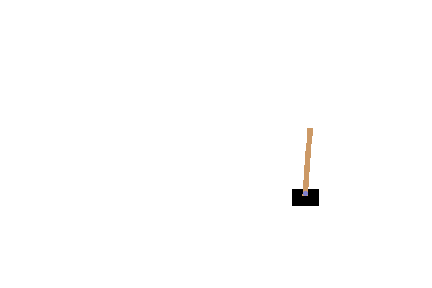
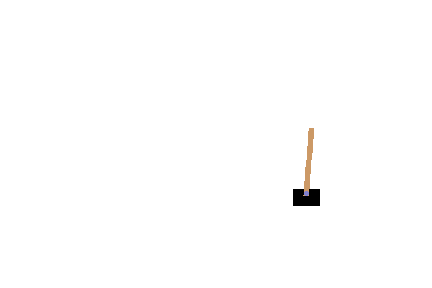
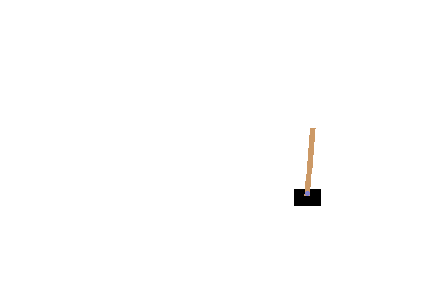
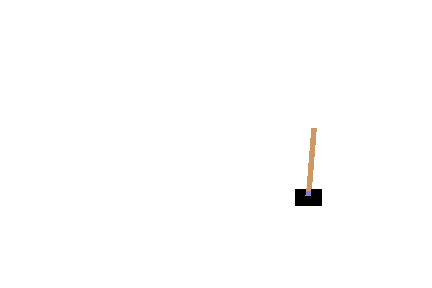
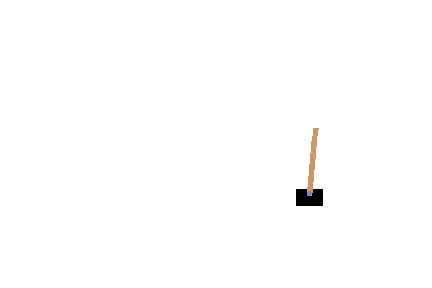
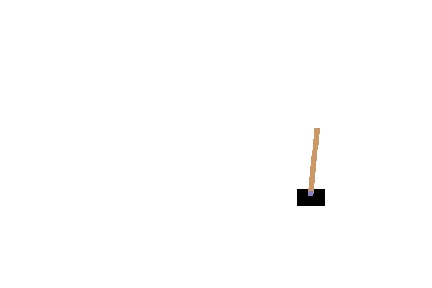
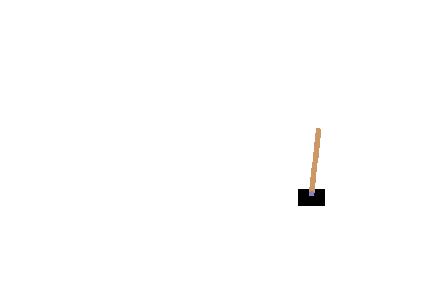
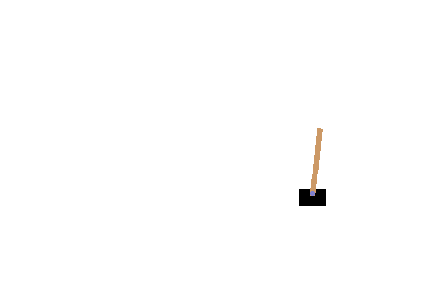
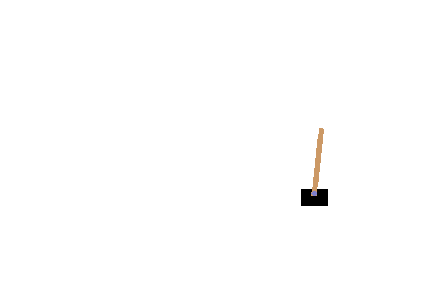
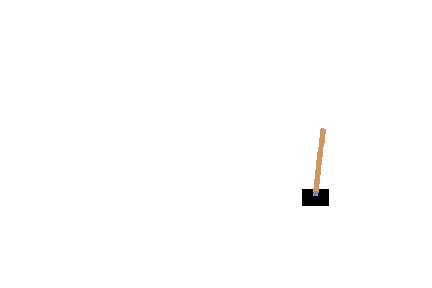
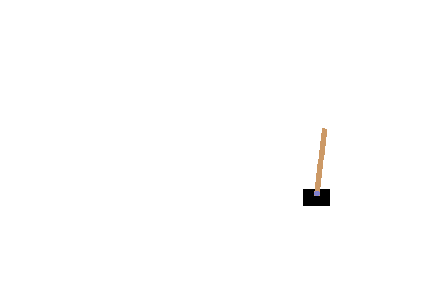
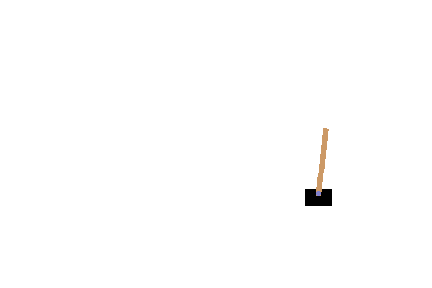
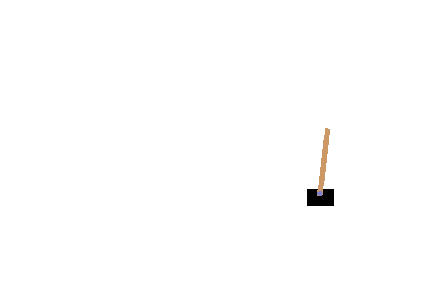
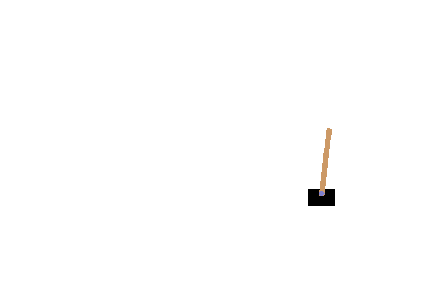
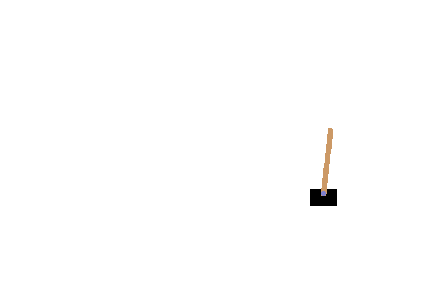
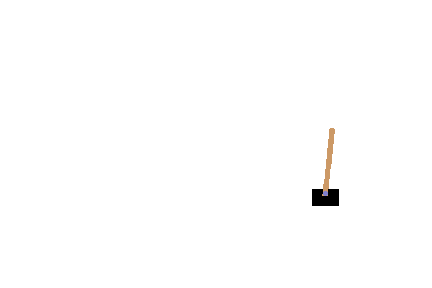
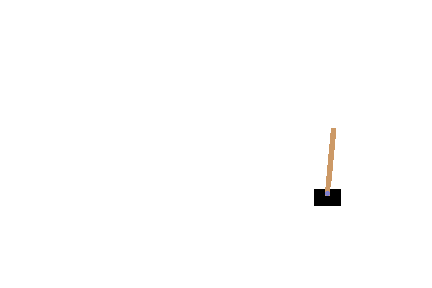
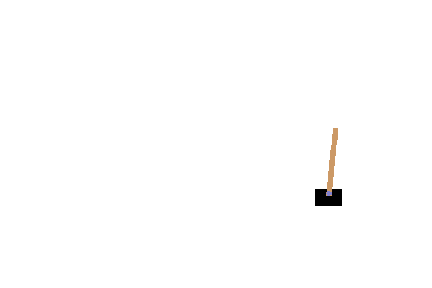
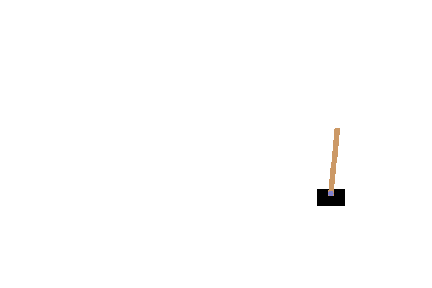
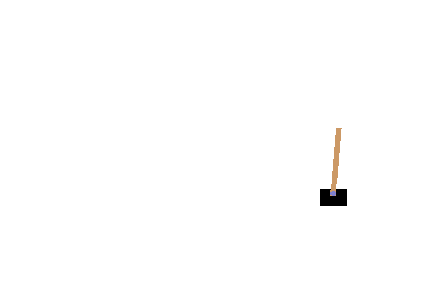
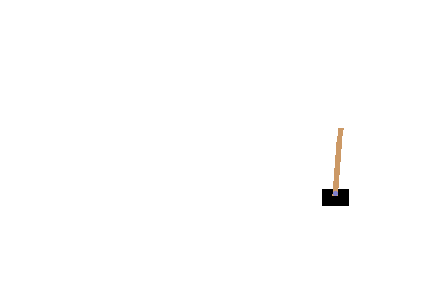
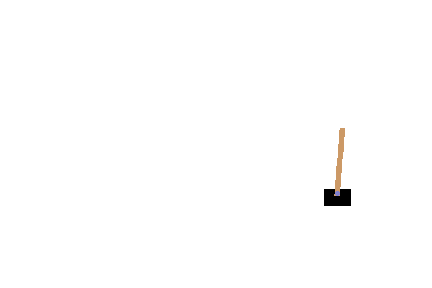
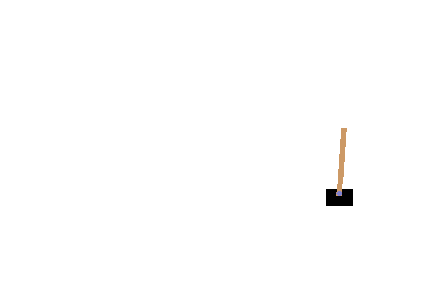
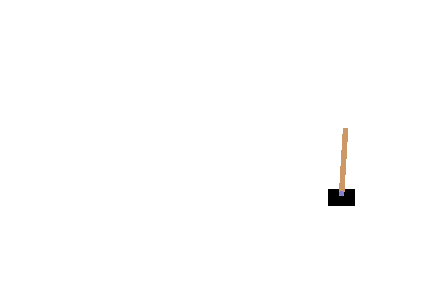
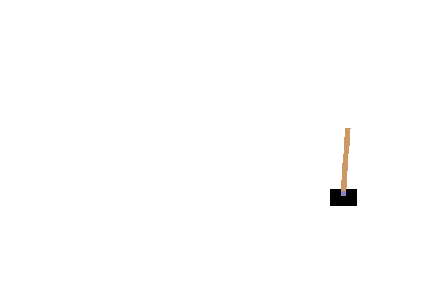
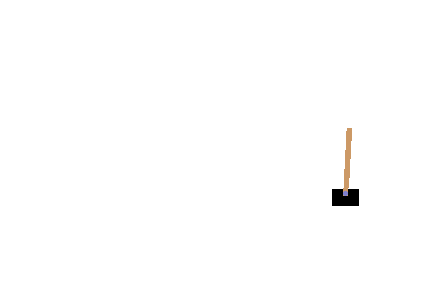
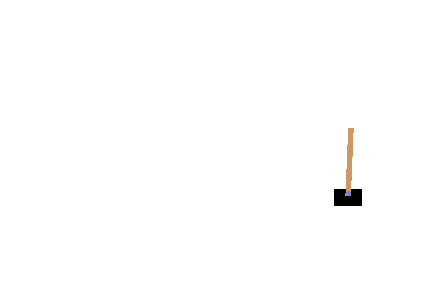
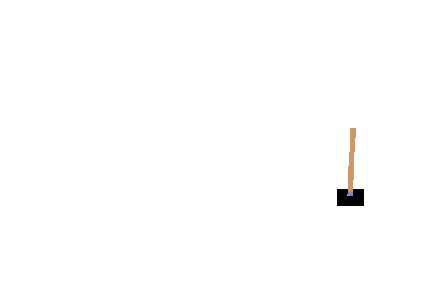
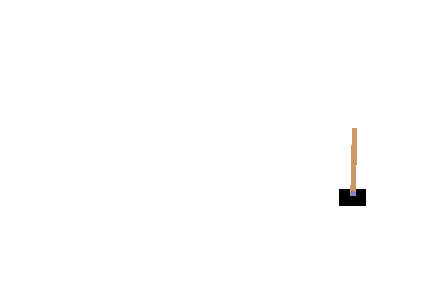
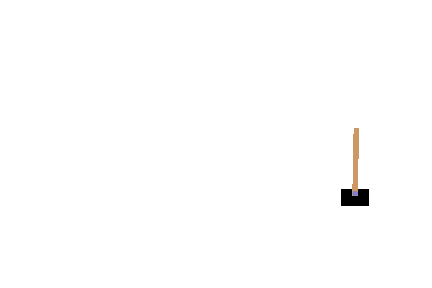
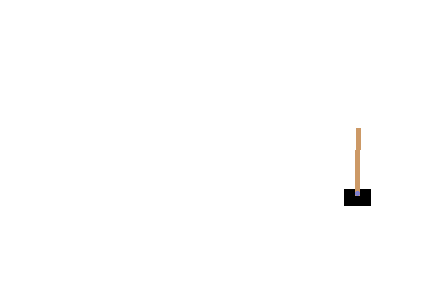
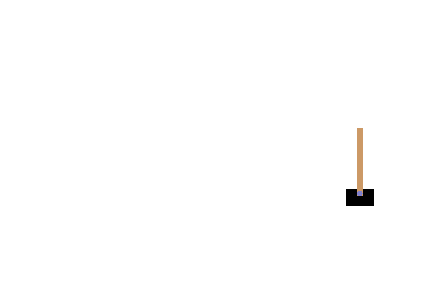
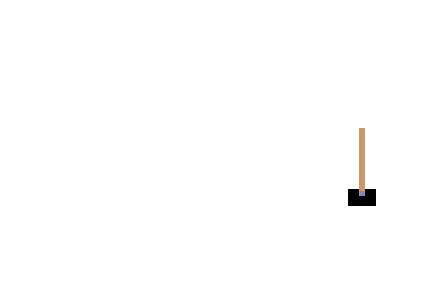
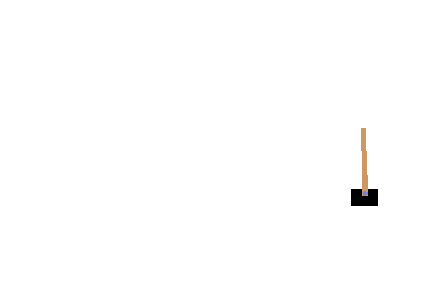
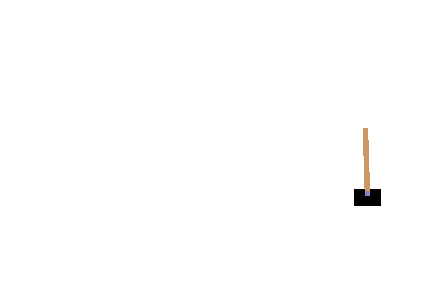
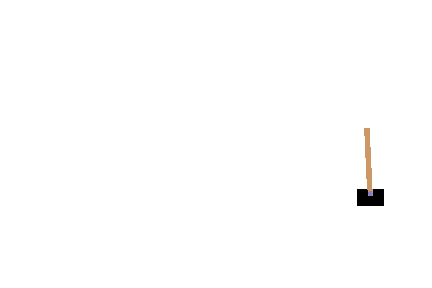
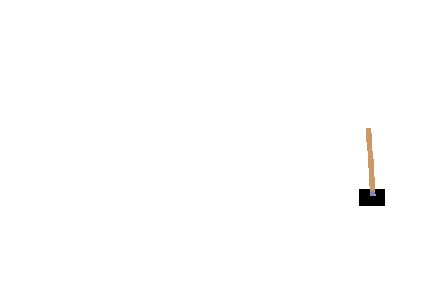
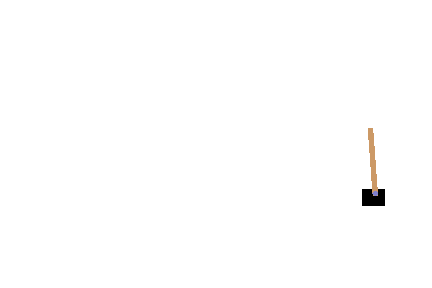
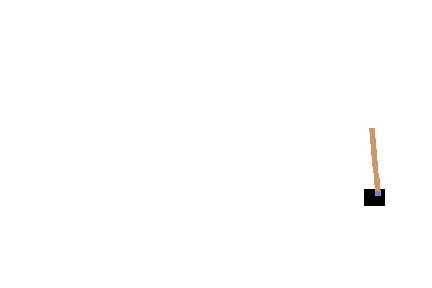
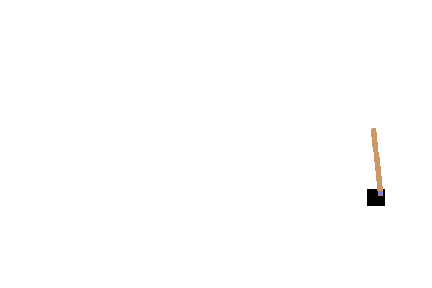
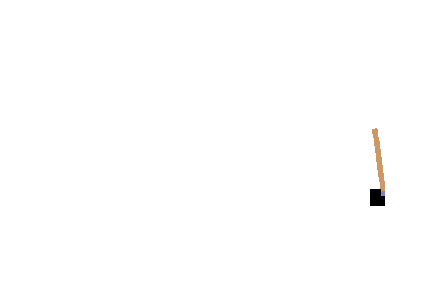

In [7]:
_, frames = play_one(env, model, 0, 0.99, lambda_, render=True)
env.render(close=True)
display_frames_as_gif(frames)